In [14]:
# !pip install zodipy
import astropy.units as u
import zodipy
import numpy as np

In [17]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
import zodipy

# For a specific wavelength (e.g. 25 μm, in the mid-IR)
model = zodipy.Model(1.25 * u.micron)

# # Or define a bandpass:

# Use Astropy's `SkyCoord` object to specify coordinates
lon = [10, 10.1, 10.2] * u.deg
lat = [90, 89, 88] * u.deg
obstimes = Time(["2022-01-01 12:00:00", "2022-01-01 12:01:00", "2022-01-01 12:02:00"])
skycoord = SkyCoord(lon, lat, obstime=obstimes, frame="galactic")

# Evaluate the zodiacal light model
emission = model.evaluate(skycoord)

print(emission)


[0.19010317 0.19139025 0.19276295] MJy / sr


In [43]:
from astropy.coordinates import SkyCoord, get_sun
from astropy.time import Time
import astropy.units as u

def pointing_geometry(target_coords, obstime):
    """
    Compute heliocentric elongation and ecliptic latitude of a target.

    Parameters
        ra_deg , dec_deg (Array float): Target Right Ascension  and Declination in degrees (ICRS).
        obstime (array astropy.time.Time): Observation time.

    Returns
        elongation (arrayfloat): Heliocentric elongation (deg) = angular separation between Sun and target along ecliptic.
        beta (array float): Heliocentric ecliptic latitude (deg) of target.
    """
    if not isinstance(obstime, Time):  # convert to astropy Time if needed
            obstime = Time(obstime)

    elongation_arr =[]
    beta_arr =[]

    for i, coord in enumerate(target_coords):
        ra_deg, dec_deg = coord

        # Target in ICRS
        target = SkyCoord(ra=ra_deg*u.deg, dec=dec_deg*u.deg, frame="icrs")
        # Sun position at obstime
        sun_icrs = get_sun(obstime[i])

        # Convert both to true ecliptic coordinates
        target_ecl = target.barycentrictrueecliptic
        sun_ecl = sun_icrs.barycentrictrueecliptic

        # Longitude difference (wrap to [0, 180])
        delta_lon = abs((target_ecl.lon - sun_ecl.lon).wrap_at(180*u.deg))
        elongation = delta_lon.deg
        # Ecliptic latitude of target
        beta = abs(target_ecl.lat.deg)

        elongation_arr.append(elongation)
        beta_arr.append(beta)

    return elongation_arr, beta_arr

# Example usage
print("Current Time (UTC):", Time.now().iso)

elong, beta = pointing_geometry(target_coords=[(230, 0)], obstime=[Time.now()])

print(f"\nElongation = {elong[0]:.2f} deg, Beta = {beta[0]:.2f} deg")


Current Time (UTC): 2025-09-23 22:37:40.773

Elongation = 7.88 deg, Beta = 17.74 deg


In [ ]:
import numpy as np

def read_zodiacal_spectrum(spec_file):
    """
    Reads a solar spectrum file in the CADS zodiacal light format.
    
    Parameters
        spec_file (str): Path to the spectrum file.
    
    Returns
        wave (np.ndarray): Wavelength array [Angstroms].
        flux (np.ndarray): Flux array [photons/cm²/s/sr/Å].
    """
    wave = []
    flux = []

    with open(spec_file, 'r') as f:
        for line in f:
            line = line.strip()
            # skip comments and blank lines
            if line.startswith('#') or line == '':
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            wave.append(float(parts[0]))
            flux.append(float(parts[1]))

    wave = np.array(wave)
    flux = np.array(flux)
    return wave, flux


# Example usage
spec_file = 'Zodiacal_spec.txt'
wavelength, flux = read_zodiacal_spectrum(spec_file)

print("First 5 entries:")
for w, f in zip(wavelength[:5], flux[:5]):
    print(f"{w:.1f} Å : {f:.5f} photons/cm²/s/sr/Å")


First 5 entries:
1195.0 Å : 0.00276 photons/cm²/s/sr/Å
1196.0 Å : 0.00466 photons/cm²/s/sr/Å
1197.0 Å : 0.00657 photons/cm²/s/sr/Å
1198.0 Å : 0.00847 photons/cm²/s/sr/Å
1199.0 Å : 0.01038 photons/cm²/s/sr/Å


In [34]:
import numpy as np

def read_zodiacal_distribution(zod_file):
    """
    Reads the 2D zodiacal light distribution file (Leinert et al.)

    Args:
        zod_file (str): Path to the zodiacal light distribution file.

    Returns:
        zod_array (np.ndarray): 2D array of zodiacal intensities (n_lat x n_lon).
        hecl_lon (np.ndarray): Helio-ecliptic longitude grid in degrees.
        hecl_lat (np.ndarray): Helio-ecliptic latitude grid in degrees.
    """
    with open(zod_file, 'r') as f:
        lines = f.readlines()

    # Skip comment lines
    lines = [line for line in lines if not line.strip().startswith('#')]

    # First non-comment line: longitudes
    hecl_lon = np.array([float(x) for x in lines[0].split()])[1:]

    # Remaining lines: each starts with latitude, then intensity values
    hecl_lat = []
    zod_data = []

    for line in lines[1:]:
        parts = line.split()
        if len(parts) < 2:
            continue
        hecl_lat.append(float(parts[0]))
        zod_data.append([float(x) for x in parts[1:]])

    hecl_lat = np.array(hecl_lat)
    zod_array = np.array(zod_data)*252  # to convert into ph cm-2 s-1 sr-1 A-1 at 5000 A, Multiply by 252     

    return zod_array, hecl_lon, hecl_lat


# Example usage
zod_file = 'leinert_dist.txt'
zod_array, lon, lat = read_zodiacal_distribution(zod_file)

print("Longitude grid:", lon)
print("Latitude grid:", lat)
print("Zodiacal array shape:", zod_array.shape) 
print("First row of intensities:", zod_array[0]) # To convert into ph cm-2 s-1 sr-1 A-1 at 5000 A, multiply by 252

Longitude grid: [ 0.  5. 10. 15. 20. 25. 30. 45. 60. 75.]
Latitude grid: [  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  60.  75.  90. 105.
 120. 135. 150. 165. 180.]
Zodiacal array shape: (19, 10)
First row of intensities: [2898000. 2898000. 2898000.  791280.  405720.  248220.  161280.   69300.
   37800.   25200.]


In [50]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator


def scale_zodiacal_spectrum(zod_dist, table_ecl, table_beta, sol_wavelengths, sol_spec, helio_ecl_arr, helio_beta_arr):
    """
    Scale the solar spectrum using the Leinert zodiacal light distribution.

    Args:
        zod_dist (np.ndarray): 2D zodiacal light intensity (lat x lon) at 5000 A.
        table_ecl (np.ndarray): Helio-ecliptic longitude grid (degrees).
        table_beta (np.ndarray): Helio-ecliptic latitude grid (degrees).
        zod_wave (np.ndarray): Wavelength array of solar spectrum (Angstroms).
        sol_spec (np.ndarray): Solar spectrum in photon units.
        helio_ecl (float): Heliocentric-ecliptic longitude of target.
        helio_beta (float): Heliocentric-ecliptic latitude of target.

    Returns:
        np.ndarray: Scaled zodiacal light spectrum.
    """

    Zodiacal_spec_arr = []

    for helio_ecl, helio_beta in zip(helio_ecl_arr, helio_beta_arr):

        # Create interpolator with linear interpolation and extrapolation
        interpolator = RegularGridInterpolator(
            (table_beta, table_ecl),  # grid: latitude, longitude
            zod_dist,
            method='linear',
            bounds_error=False,
            fill_value=None  # None allows extrapolation
        )
        # Evaluate zodiacal intensity at the target coordinates # Absolute latitude because table is symmetric
        zod_intensity = interpolator([[abs(helio_beta), helio_ecl]])[0]

        # Find index closest to 5000 Å
        wave_index = np.searchsorted(sol_wavelengths, 5000, side='right') - 1
        wave_index = np.clip(wave_index, 0, len(sol_wavelengths)-1)

        # Scale factor
        zod_scale = zod_intensity / sol_spec[wave_index]

        # print(f"Solar intensity at 5000 Å: {sol_spec[wave_index]:.4f} ph/cm²/s/sr/Å")
        # print(f"Zodiacal intensity at target: {zod_intensity:.4f} ph/cm²/s/sr/Å")
        # print(f"Scaling factor (at 5000 Å): {zod_scale:.4f}")

        # Apply scaling
        sol_spec_scaled = sol_spec * zod_scale
        Zodiacal_spec_arr.append(sol_spec_scaled)
    
    return Zodiacal_spec_arr


# Example usage
print("Current Time (UTC):", Time.now().iso)
target_coords = [(230, 0), (240, 10)]  # degrees
time_arr = [Time.now(), Time.now()]


elong_arr, beta_arr = pointing_geometry(target_coords, time_arr)
print(f"Elongation = {elong[0]:.2f} deg, Beta = {beta[0]:.2f} deg")

spec_file = 'Zodiacal_spec.txt'
wavelength, flux = read_zodiacal_spectrum(spec_file)

zod_file = 'leinert_dist.txt'
zod_array, lon, lat = read_zodiacal_distribution(zod_file)

scaled_spectrum = scale_zodiacal_spectrum(zod_array, lon, lat, wavelength, flux, elong_arr, beta_arr)


Current Time (UTC): 2025-09-23 22:47:38.033
Elongation = 7.88 deg, Beta = 17.74 deg


25763 25763 2


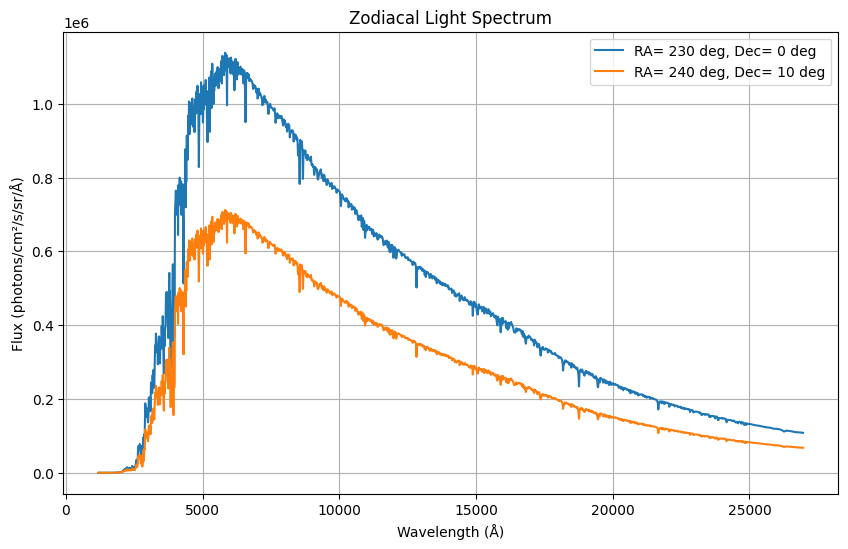

In [52]:
# Plot results
import matplotlib.pyplot as plt

print(len(wavelength), len(flux), len(scaled_spectrum))

plt.figure(figsize=(10, 6))
# plt.plot(wavelength, flux, label='Original Solar Spectrum', color='blue')
for i, scaled_spectra in enumerate(scaled_spectrum):
    target_dec = target_coords[i][1]
    target_ra = target_coords[i][0]
    plt.plot(wavelength, scaled_spectra, label=f'RA= {target_ra} deg, Dec= {target_dec} deg')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (photons/cm²/s/sr/Å)')
plt.title(f'Zodiacal Light Spectrum')
plt.legend()
plt.grid()
  
plt.show()

